In [1]:
import PIL
from PIL import Image, ImageOps, ImageDraw
import os
import numpy as np
from tqdm.notebook import tqdm
import subprocess
import multiprocess
from multiprocess import Pool
import math
import seaborn as sns
import plotly.express as px

from bus_data import *


In [2]:
if os.uname()[1] == "media":
    # Florin's gaming PC
    data_volume = "/home/florin/data"
else:
    # Google Colab
    from google.colab import drive

    gdrive_path = "/content/gdrive"
    drive.mount(gdrive_path, force_remount=False)
    data_volume = gdrive_path + "/MyDrive"


In [3]:
buv_df = buv_dataset_make(data_volume)
buv_df


,dataset,class,video,image,str_index
0,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000000.png,00000
1,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000001.png,00001
2,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000002.png,00002
3,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000003.png,00003
4,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000004.png,00004
...,...,...,...,...,...
25267,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000186.png,25267
25268,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000187.png,25268
25269,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000188.png,25269
25270,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000189.png,25270


In [4]:
basedir = "frames"
sfdir = basedir + "/masks_segformer"
unetdir = basedir + "/masks_unet"
outdir = basedir + "/video"

shutil.rmtree(outdir, ignore_errors=True)
os.makedirs(outdir, exist_ok=True)


In [5]:
def eval_performance(src_df):
    pixel_pred = pd.DataFrame(
        [[0, 0, 0], [0, 0, 0]],
        index=["unet", "segformer"],
        columns=["benign", "malignant", "total"],
    )
    first_index = src_df.index.to_list()[0]
    video_id = src_df.loc[first_index, "video"]
    video_class = src_df.loc[first_index, "class"]

    for _, row in src_df.iterrows():
        arr_unet = np.array(
            Image.open(unetdir + "/f" + row["str_index"] + ".png")
        ).astype(np.uint8)
        pixel_pred.loc["unet", "total"] += (arr_unet != 0).sum()
        pixel_pred.loc["unet", "benign"] += (arr_unet == 1).sum()
        pixel_pred.loc["unet", "malignant"] += (arr_unet == 2).sum()

        arr_sf = np.array(Image.open(sfdir + "/f" + row["str_index"] + ".png")).astype(
            np.uint8
        )
        pixel_pred.loc["segformer", "total"] += (arr_sf != 0).sum()
        pixel_pred.loc["segformer", "benign"] += (arr_sf == 1).sum()
        pixel_pred.loc["segformer", "malignant"] += (arr_sf == 2).sum()

    unet_pred = pixel_pred.loc["unet", video_class]
    unet_total = pixel_pred.loc["unet", "total"]
    sf_pred = pixel_pred.loc["segformer", video_class]
    sf_total = pixel_pred.loc["segformer", "total"]

    return (
        video_id,
        unet_pred,
        unet_total,
        sf_pred,
        sf_total,
        video_class,
    )


def process_img_mask(func_input):
    src_df, perf_metrics = func_input
    img_size = 256
    img_size2 = 2 * img_size
    img_size3 = 3 * img_size

    for _, row in src_df.iterrows():
        img = (
            Image.open(row["image"])
            .resize((img_size, img_size), resample=PIL.Image.Resampling.BILINEAR)
            .convert(mode="RGB")
        )
        mask_unet = Image.open(unetdir + "/f" + row["str_index"] + ".png").resize(
            (img_size, img_size), resample=PIL.Image.Resampling.BILINEAR
        )
        mask_sf = Image.open(sfdir + "/f" + row["str_index"] + ".png").resize(
            (img_size, img_size), resample=PIL.Image.Resampling.BILINEAR
        )

        mask_col_unet = ImageOps.colorize(
            mask_unet,
            black=(0, 0, 127),
            white=(255, 127, 127),
            mid=(127, 255, 127),
            blackpoint=0,
            whitepoint=2,
            midpoint=1,
        )

        mask_col_sf = ImageOps.colorize(
            mask_sf,
            black=(0, 0, 127),
            white=(255, 127, 127),
            mid=(127, 255, 127),
            blackpoint=0,
            whitepoint=2,
            midpoint=1,
        )

        blend_unet = Image.blend(img, mask_col_unet, 0.2)
        blend_sf = Image.blend(img, mask_col_sf, 0.2)

        img_text = row["class"]
        if img_text == "benign":
            img_text_color = (127, 255, 127)
        elif img_text == "malignant":
            img_text_color = (255, 127, 127)
        else:
            img_text_color = (255, 255, 255)

        draw_img = ImageDraw.Draw(img)
        draw_img.text(xy=(2, img_size - 12), text=img_text, fill=img_text_color)
        draw_img.text(xy=(2, 0), text="id=" + row["video"], fill=(255, 255, 255))

        draw_unet = ImageDraw.Draw(blend_unet)
        draw_unet.text(
            xy=(2, img_size - 12),
            text="perf=" + str(perf_metrics[0]),
            fill=img_text_color,
        )
        draw_unet.text(xy=(2, 0), text="U-Net / ResNet34", fill=(255, 255, 255))

        draw_sf = ImageDraw.Draw(blend_sf)
        draw_sf.text(
            xy=(2, img_size - 12),
            text="perf=" + str(perf_metrics[1]),
            fill=img_text_color,
        )
        draw_sf.text(xy=(2, 0), text="SegFormer MiT-b3", fill=(255, 255, 255))

        final_frame = Image.new(mode="RGB", size=(img_size3, img_size))
        final_frame.paste(img, (0, 0))
        final_frame.paste(blend_unet, (img_size, 0))
        final_frame.paste(blend_sf, (img_size2, 0))
        final_frame.save(outdir + "/f" + row["str_index"] + ".png", format="png")


In [6]:
if __name__ == "__main__":
    n_cpu = multiprocess.cpu_count()
    p = Pool(processes=n_cpu)
    video_list = buv_df["video"].unique()
    perf_results = []
    for i in tqdm(
        list(range(0, len(video_list), n_cpu)), desc="performance evaluation"
    ):
        video_to_measure = []
        for v in range(i, i + n_cpu):
            if v >= len(video_list):
                break
            vid_df = buv_df[buv_df["video"] == video_list[v]]
            vid_df.reset_index(inplace=True)
            video_to_measure.append(vid_df)
        work_out = p.map(eval_performance, video_to_measure)
        perf_results += work_out

    for v in tqdm(video_list, desc="create video frames"):
        vid_df = buv_df[buv_df["video"] == v]
        vid_df.reset_index(inplace=True)
        df_step = math.ceil(len(vid_df) / n_cpu)
        perf_metrics = (0, 0)
        for r in perf_results:
            if r[0] == v:
                perf_metrics = (round(r[1], 4), round(r[2], 4))
        index_ranges = []
        for start in range(0, len(vid_df), df_step):
            index_ranges.append((vid_df.iloc[start : start + df_step], perf_metrics))
        p.map(process_img_mask, index_ranges)

    p.close()


performance evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

create video frames:   0%|          | 0/186 [00:00<?, ?it/s]

In [7]:
subprocess.run("./make_video.sh")


y4m [info]: 768x256p 1:1 @ 25/1 fps (cfr)
x264 [info]: using SAR=1/1
x264 [info]: using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x264 [info]: profile High, level 2.1, 4:2:0, 8-bit
x264 [info]: frame I:294   Avg QP:18.16  size: 40214                           
x264 [info]: frame P:19650 Avg QP:20.95  size: 14551
x264 [info]: frame B:5328  Avg QP:23.86  size:  6388
x264 [info]: consecutive B-frames: 70.5%  3.0%  3.3% 23.2%
x264 [info]: mb I  I16..4:  0.7% 71.3% 28.0%
x264 [info]: mb P  I16..4:  0.0%  4.4%  1.5%  P16..4: 40.5% 31.3% 20.1%  0.0%  0.0%    skip: 2.1%
x264 [info]: mb B  I16..4:  0.0%  0.9%  0.9%  B16..8: 18.3%  4.6%  4.2%  direct:35.1%  skip:36.0%  L0:35.2% L1:34.3% BI:30.6%
x264 [info]: 8x8 transform intra:72.1% inter:56.4%
x264 [info]: coded y,uvDC,uvAC intra: 96.7% 14.3% 12.3% inter: 80.1% 3.3% 1.8%
x264 [info]: i16 v,h,dc,p: 52% 21% 20%  8%
x264 [info]: i8 v,h,dc,ddl,ddr,vr,hd,vl,hu:  5% 31% 11%  6%  7%  4% 14%  5% 17%
x264 [info]: i4 v,h,dc,ddl,ddr

CompletedProcess(args='./make_video.sh', returncode=0)

In [8]:
perf_df = pd.DataFrame(
    perf_results,
    columns=[
        "video",
        "unet_pred",
        "unet_total",
        "segformer_pred",
        "segformer_total",
        "class",
    ],
)

perf_df["unet"] = perf_df["unet_pred"] / perf_df["unet_total"]
perf_df["segformer"] = perf_df["segformer_pred"] / perf_df["segformer_total"]
perf_df.to_csv(basedir + "/perf_results.csv", index=False)

perf_df


,video,unet_pred,unet_total,segformer_pred,segformer_total,class,unet,segformer
0,263b86b85a58f270,209231,242432,1261203,1261203,benign,0.863050,1.000000
1,2cda21c3aab26332,62973,660411,438776,3466823,benign,0.095354,0.126564
2,32a6532065f51cec,725739,817660,4144535,4164626,benign,0.887580,0.995176
3,391ae00452fe2e99,20557,237485,214091,908546,benign,0.086561,0.235641
4,4414661bcb60d5cf,35194,37915,207514,207514,benign,0.928234,1.000000
...,...,...,...,...,...,...,...,...
181,x9c1c965d274c457,895589,912003,4733823,6181461,malignant,0.982002,0.765810
182,xb60099fde76c0ea,2551537,2876927,13281628,15652084,malignant,0.886897,0.848553
183,xc92f65176f4b7a7,1223961,1262357,6563842,8020740,malignant,0.969584,0.818359
184,xe60a9301eb8c62f,620402,633248,3414556,3423733,malignant,0.979714,0.997320


In [9]:
perf_df = pd.read_csv(basedir + "/perf_results.csv")


In [10]:
consistency_df = pd.DataFrame(
    index=["benign", "malignant"], columns=["unet", "segformer"], dtype=np.float64
)

consistency_df.loc["benign", "unet"] = (
    perf_df[perf_df["class"] == "benign"]["unet_pred"].sum()
    / perf_df[perf_df["class"] == "benign"]["unet_total"].sum()
)
consistency_df.loc["malignant", "unet"] = (
    perf_df[perf_df["class"] == "malignant"]["unet_pred"].sum()
    / perf_df[perf_df["class"] == "malignant"]["unet_total"].sum()
)

consistency_df.loc["benign", "segformer"] = (
    perf_df[perf_df["class"] == "benign"]["segformer_pred"].sum()
    / perf_df[perf_df["class"] == "benign"]["segformer_total"].sum()
)
consistency_df.loc["malignant", "segformer"] = (
    perf_df[perf_df["class"] == "malignant"]["segformer_pred"].sum()
    / perf_df[perf_df["class"] == "malignant"]["segformer_total"].sum()
)

consistency_df


,unet,segformer
benign,0.345397,0.581847
malignant,0.905014,0.854745


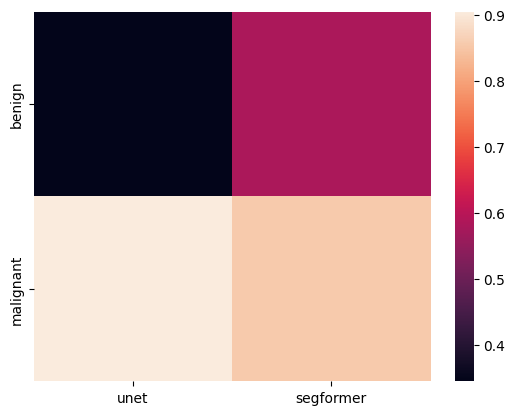

In [15]:
sns.heatmap(consistency_df);


In [16]:
px.histogram(
    data_frame=perf_df[["unet", "segformer"]],
    barmode="relative",
    title="Histogram: overall prediction consistency",
    nbins=200,
    width=800,
    height=400,
)


In [17]:
px.histogram(
    data_frame=perf_df[["unet", "segformer"]][perf_df["class"] == "benign"],
    barmode="relative",
    title="Histogram: benign prediction consistency",
    nbins=200,
    width=800,
    height=400,
)


In [18]:
px.histogram(
    data_frame=perf_df[["unet", "segformer"]][perf_df["class"] == "malignant"],
    barmode="relative",
    title="Histogram: malignant prediction consistency",
    nbins=200,
    width=800,
    height=400,
)
